**2장 – 머신러닝 프로젝트 처음부터 끝까지**

*머신러닝 부동산 회사에 오신 것을 환영합니다! 여러분이 할 작업은 캘리포니아 지역 주택의 여러 특성을 사용해 중간 가격을 예측하는 것입니다.*

*이 노트북은 2장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다.*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 데이터 가져오기

In [2]:
import pandas as pd
import pickle
from bigquery_worker import BigqueryWorker
from IPython.display import display

bigquery_worker = BigqueryWorker()
try:
    with open('datasets/df1.pickle', 'rb') as f:
        df1 = pickle.load(f)
except:
  df1 = bigquery_worker.get_daily_info_all('daily_items_indicator_info_all').drop_duplicates(['itemname', 'date'], 'first')
try:
    with open('datasets/df2.pickle', 'rb') as f:
        df2 = pickle.load(f)
except:
  df2 = bigquery_worker.get_daily_info_all('daily_items_info_all', start_date='2015-09-01').drop_duplicates(['itemname', 'date'], 'first')
df3 = bigquery_worker.get_itemcodes_info()
df4 = pd.concat([
    bigquery_worker.get_daily_item_info(('kospi', '코스피', 'kospi')),
    bigquery_worker.get_daily_item_info(('kosdaq', '코스닥', 'kosdaq')),
])

display(df1, df2, df3, df4)

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
0,네패스아크,2020-11-17,16.624,9.985,13.267,4.869,NaN,NaN,45.815,230.38,1.7,0.614,243268200.0
1,네패스아크,2020-11-18,15.357,9.223,12.256,4.497,NaN,NaN,45.815,230.38,1.7,0.614,224724500.0
2,네패스아크,2020-11-19,16.387,9.843,13.079,4.799,NaN,NaN,45.815,230.38,1.7,0.614,239810900.0
3,네패스아크,2020-11-20,17.998,10.810,14.364,5.271,NaN,NaN,45.815,230.38,1.7,0.614,263383400.0
4,아난티,2020-11-10,-14.982,2.050,-34.245,16.323,-13.52,-4.91,-2.524,-6.78,39.9,0.024,711916670.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163145,와이오엠,2016-08-22,-6.012,4.002,NaN,NaN,-67.41,-27.73,0.000,0.00,NaN,0.000,59248400.0
2163146,슈프리마,2016-07-01,0.000,2.552,NaN,NaN,NaN,NaN,0.000,0.00,NaN,0.000,196824000.0
2163147,아이에이네트웍스,2016-08-01,-91.524,4.665,NaN,NaN,-7.51,-1.28,0.000,0.00,NaN,0.000,35637724.0
2163148,와이오엠,2016-09-02,-6.012,4.002,NaN,NaN,-67.41,-27.73,0.000,0.00,NaN,0.000,59248400.0


,itemname,date,open,high,low,close,volume
0,WI,2017-09-21,1104,1145,1024,1024,238155
1,WI,2019-07-03,1784,1814,1780,1792,57206
2,WI,2020-02-05,1820,1840,1780,1792,50494
3,WI,2016-03-07,2800,2908,2779,2816,690287
4,WI,2019-01-02,1849,1849,1754,1793,27881
...,...,...,...,...,...,...,...
2557905,피엔케이피부임상연구센타,2020-10-30,21800,23150,21750,22250,126879
2557906,피엔케이피부임상연구센타,2020-09-22,23500,23550,22150,22250,151167
2557907,피엔케이피부임상연구센타,2020-10-29,21950,22350,21300,21750,68232
2557908,피엔케이피부임상연구센타,2020-09-21,25400,25850,23400,23800,161173


,itemcode,itemname,market,sector,main_product,listing_date,settlement_month,representative_name,homepage,area
0,950140,잉글우드랩,kosdaq,기타 화학제품 제조업,기초화장품(화장품 제조),2016-10-14,12월,조현철,http://www.englewoodlab.com,미국
1,900100,뉴프라이드,kosdaq,자동차 부품 및 내장품 판매업,인터모달 신생 및 재생타이어,2010-04-21,12월,John Lee,http://www.npcims.com,미국
2,950200,소마젠,kosdaq,"그외 기타 전문, 과학 및 기술 서비스업","유전체 분석 서비스 (NGS, CES 등)",2020-07-13,12월,Ryan W. Kim (김운봉),None,미국
3,950160,코오롱티슈진,kosdaq,기초 의약물질 및 생물학적 제제 제조업,골관절염 치료제,2017-11-06,12월,"노문종, 한성수",http://tissuegene.com,미국
4,950130,엑세스바이오,kosdaq,의료용품 및 기타 의약 관련제품 제조업,"말라리아 진단키트(RDT), HIV 진단키트(RDT)",2013-05-30,12월,최영호,http://www.accessbio.net,미국
...,...,...,...,...,...,...,...,...,...,...
2243,006220,제주은행,kospi,은행 및 저축기관,"은행업무,외국환업무,신탁업무",1972-12-28,12월,서현주,http://www.e-jejubank.com,제주특별자치도
2244,089590,제주항공,kospi,항공 여객 운송업,"여객운송서비스, 화물운송서비스",2015-11-06,12월,김이배,http://www.jejuair.net,제주특별자치도
2245,066110,한프,kosdaq,컴퓨터 및 주변장치 제조업,OPC Drum,2002-07-16,12월,유한성,http://www.baiksanopc.co.kr,제주특별자치도
2246,032350,롯데관광개발,kospi,여행사 및 기타 여행보조 서비스업,"국내외여행알선,관광개발,전세운수,항공권매매대행",2006-06-08,12월,"김기병, 백현, 김한준",http://lottetour.com,제주특별자치도


,itemname,open,high,low,close,volume
date,,,,,,
2000-01-04,kospi,1028,1066,1016,1059,195899000
2000-01-05,kospi,1006,1047,984,986,257696000
2000-01-06,kospi,1013,1014,953,960,203524000
2000-01-07,kospi,949,970,930,948,215664000
2000-01-10,kospi,979,994,965,987,240175000
...,...,...,...,...,...,...
2020-11-16,kosdaq,843,849,841,847,1619880000
2020-11-17,kosdaq,846,846,836,839,1789493000
2020-11-18,kosdaq,842,852,840,851,2330367000


In [32]:
with open('datasets/df1.pickle', 'wb') as f:
    pickle.dump(df1, f)
with open('datasets/df2.pickle', 'wb') as f:
    pickle.dump(df2, f)

In [3]:
display(df1.info(), df2.info(), df3.info(), df4.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2163150 entries, 0 to 2163149
Data columns (total 13 columns):
itemname     object
date         datetime64[ns]
PER          float64
PBR          float64
PCR          float64
PSR          float64
ROE          float64
ROA          float64
OPROA        float64
OPROE        float64
EV_EBITDA    float64
GP_A         float64
NOS          float64
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 231.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557910 entries, 0 to 2557909
Data columns (total 7 columns):
itemname    object
date        datetime64[ns]
open        int64
high        int64
low         int64
close       int64
volume      int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 156.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 10 columns):
itemcode               2248 non-null object
itemname               2248 non-null object
market              

None

None

None

None

In [4]:
import numpy as np

for c in ['market', 'sector', 'main_product', 'settlement_month', 'representative_name', 'homepage', 'area']:
  display(df3[c].value_counts())

kosdaq    1449
kospi      799
Name: market, dtype: int64

특수 목적용 기계 제조업      136
전자부품 제조업           119
소프트웨어 개발 및 공급업     119
자동차 신품 부품 제조업       92
기타 금융업              90
                  ... 
산업용 기계 및 장비 임대업      1
사업시설 유지·관리 서비스업      1
보험 및 연금관련 서비스업       1
시장조사 및 여론조사업         1
석탄 광업                1
Name: sector, Length: 153, dtype: int64

기업인수합병                       37
지주회사                         18
지주사업                          9
모바일게임                         7
화장품                           7
                             ..
증권투자회사                        1
전문의약품, 건강기능식품                 1
DK-Lok 피팅, D-Pro 밸브           1
점화코일, 스파크플러그                  1
자동차보험,화재보험,해상보험,특종보험,장기보험     1
Name: main_product, Length: 2088, dtype: int64

12월    2193
03월      22
06월      19
09월       5
11월       4
08월       2
02월       2
07월       1
Name: settlement_month, dtype: int64

김상우                4
박세철                3
이동훈                3
김형철                3
김영주                3
                  ..
엄대식 (단독대표)         1
이의철,이강봉(각자대표이사)    1
유인수                1
이형환                1
송효순                1
Name: representative_name, Length: 2143, dtype: int64

http://www.woory.com            2
http://www.eagon.com            2
http://www.sempio.com           2
http://www.crown.co.kr          2
http://www.ubiquoss.com         2
                               ..
http://www.longtukorea.kr/      1
http://www.aloys.co.kr          1
http://www.isuchemical.co.kr    1
http://www.gjshinsegae.com      1
http://www.inctech.co.kr        1
Name: homepage, Length: 2060, dtype: int64

서울특별시      905
경기도        632
충청남도        89
경상남도        89
인천광역시       80
충청북도        74
부산광역시       74
경상북도        55
대구광역시       55
대전광역시       45
전라북도        27
울산광역시       25
강원도         20
전라남도        20
광주광역시       18
세종특별자치시      9
제주특별자치도      9
홍콩           9
미국           5
케이맨 제도       5
일본           3
Name: area, dtype: int64

In [5]:
display(
    df1.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))),
    df2.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))),
    df3.describe(),
    df4.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))),
)

,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
count,2.15856e+06,2.15856e+06,1.73608e+06,1.73608e+06,2.14615e+06,2.14615e+06,2.15859e+06,2.15859e+06,1.59002e+06,2.16315e+06,2.15859e+06
mean,16.3382,2.12131,9.13523,8.71918,-0.561805,0.787756,2.78274,4.34913,46.2143,0.116264,7.72084e+08
std,240.439,6.82102,340.775,241.436,53.9787,17.0035,9.69943,112.547,408.909,0.19331,7.28942e+09
min,-8110,-13.333,-31200,0,-2598.73,-735.63,-365.714,-2800,0,-1.415,0
25%,-3.371,0.733,2.551,0.459,-3.16,-1.58,0,0,7.31,0,6.35276e+07
50%,9.548,1.229,7.971,1.031,4.39,2.4,3.117,5.691,11.66,0.059,1.18856e+08
75%,22.663,2.279,17.277,2.373,10.55,6.22,6.813,12.621,23.15,0.168,2.77012e+08
max,11817.7,922.414,26650,24850,3599.36,718.45,168.924,14133.3,20000.3,3.235,4.02484e+11


,open,high,low,close,volume
count,2.55791e+06,2.55791e+06,2.55791e+06,2.55791e+06,2.55791e+06
mean,22144.9,22537.8,21748,22247.5,658819
std,65254.8,66219.4,64303,65264.7,4.07575e+06
min,0,0,0,107,0
25%,2928,2997,2860,3000,27510
50%,6350,6490,6210,6410,96856
75%,16150,16500,15800,16250,325719
max,1.749e+06,1.749e+06,1.692e+06,1.749e+06,8.51967e+08


,itemcode,itemname,market,sector,main_product,listing_date,settlement_month,representative_name,homepage,area
count,2248,2248,2248,2248,2230,2248,2248,2248,2082,2248
unique,2248,2248,2,153,2088,1674,8,2143,2060,21
top,005110,에이텍,kosdaq,특수 목적용 기계 제조업,기업인수합병,1996-07-03 00:00:00,12월,김상우,http://www.woory.com,서울특별시
freq,1,1,1449,136,37,8,2193,4,2,905
first,NaN,NaN,NaN,NaN,NaN,1956-03-03 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-11-20 00:00:00,NaN,NaN,NaN,NaN


,open,high,low,close,volume
count,10314,10314,10314,10314,10314
mean,1107.09,1114.02,1097.58,1105.85,5.11798e+08
std,653.937,657.102,650.021,653.843,2.73765e+08
min,247,272,245,261,6.495e+07
25%,565,568,560,564,3.31748e+08
50%,764,770,756,763,4.46804e+08
75%,1839,1851,1817.75,1838,6.18540e+08
max,2894,2925,2815,2834,2.95168e+09


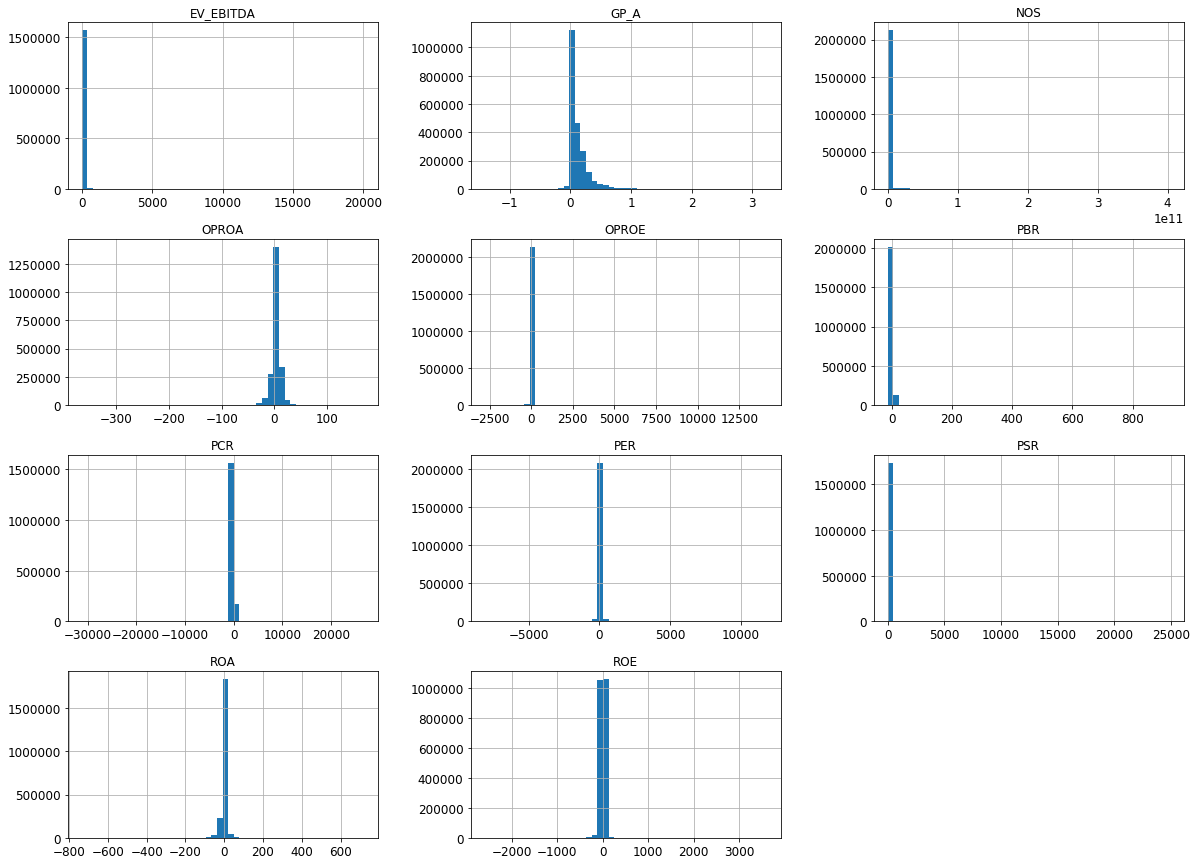

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
df1.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
temp_df = df1
for c in ['PER', 'PBR', 'PCR', 'PSR', 'ROE', 'ROA', 'OPROA', 'OPROE', 'EV_EBITDA']:
  temp_df = pd.merge(temp_df, df1[np.abs(df1[c]-df1[c].mean()) <= (3*df1[c].std())], how ='inner')
display(temp_df)

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS
0,아난티,2020-11-10,-14.982,2.050,-34.245,16.323,-13.52,-4.91,-2.524,-6.78,39.90,0.024,711916670.0
1,아난티,2020-11-17,-15.018,2.055,-34.327,16.362,-13.52,-4.91,-2.524,-6.78,39.90,0.024,713613730.0
2,아난티,2020-11-13,-15.179,2.077,-34.694,16.537,-13.52,-4.91,-2.524,-6.78,39.90,0.024,721250500.0
3,아난티,2020-11-18,-14.982,2.050,-34.245,16.323,-13.52,-4.91,-2.524,-6.78,39.90,0.024,711916670.0
4,아난티,2020-11-11,-15.286,2.092,-34.939,16.654,-13.52,-4.91,-2.524,-6.78,39.90,0.024,726341680.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532482,이에스에이,2017-02-07,-4.284,2.775,-7.667,25.746,-72.26,-27.72,0.000,0.00,16.81,0.000,42854175.0
1532483,엔시트론,2017-05-10,-34.271,3.424,32.574,1.084,-10.67,-3.90,0.000,0.00,18.30,0.000,45280270.0
1532484,서암기계공업,2017-04-07,50.811,0.853,15.473,1.491,1.69,1.47,0.000,0.00,27.12,0.000,47376000.0
1532485,서암기계공업,2017-10-30,46.486,0.780,14.156,1.364,1.69,1.47,0.000,0.00,27.12,0.000,43344000.0


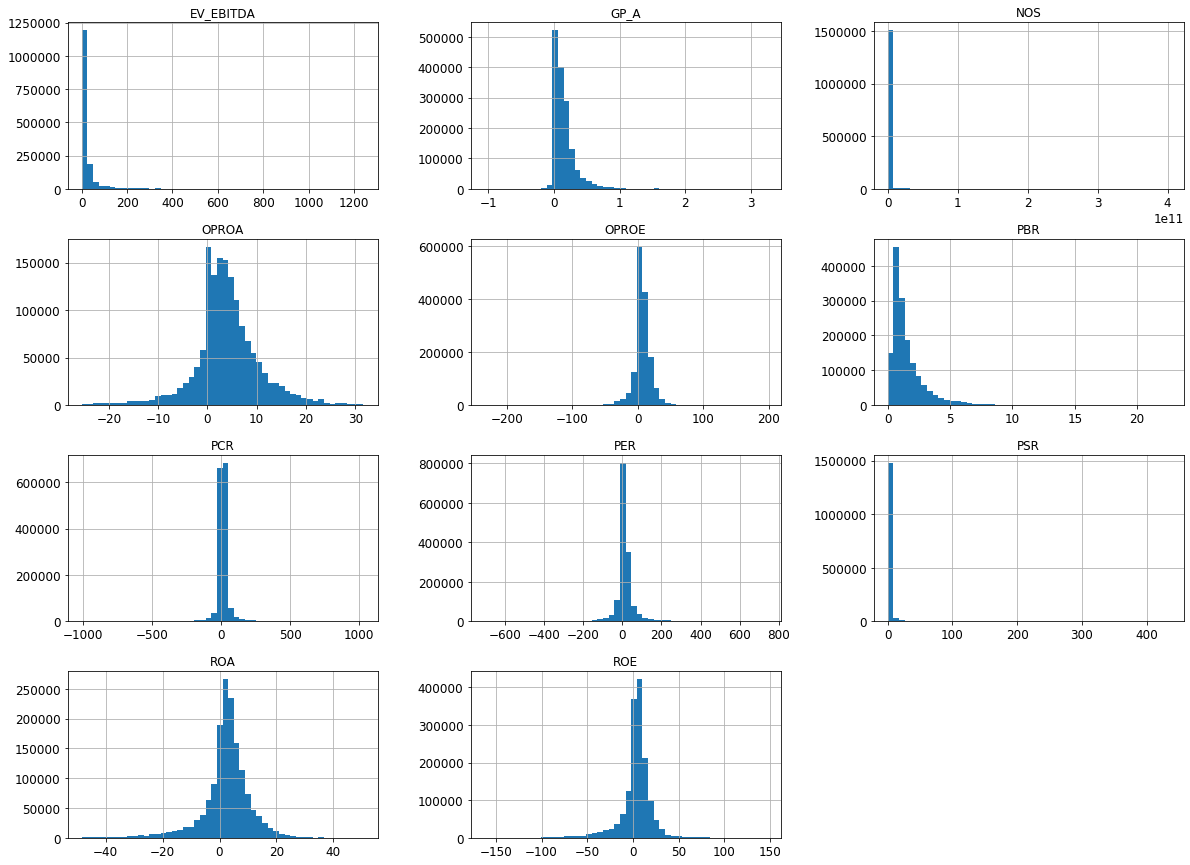

In [8]:
df1 = temp_df
df1.hist(bins=50, figsize=(20,15))
plt.show()

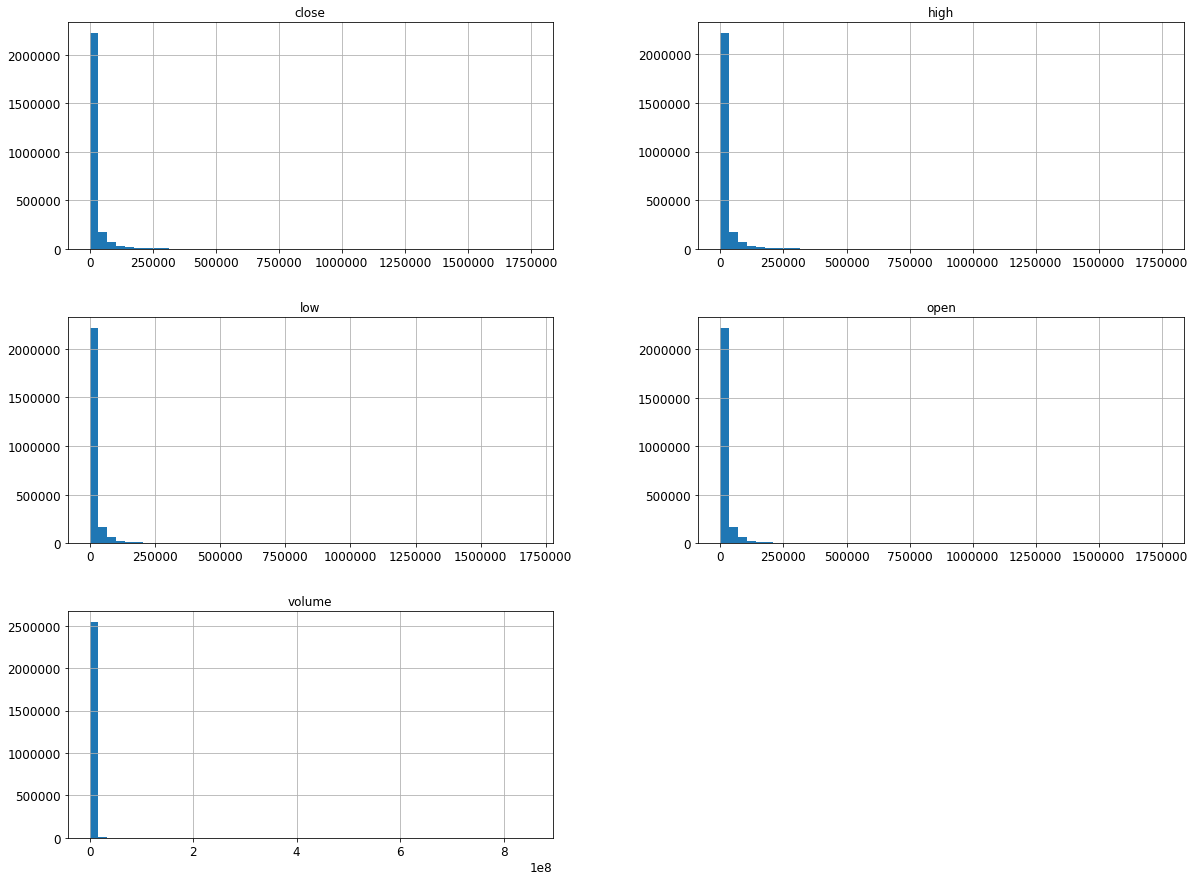

In [9]:
df2.hist(bins=50, figsize=(20,15))
plt.show()

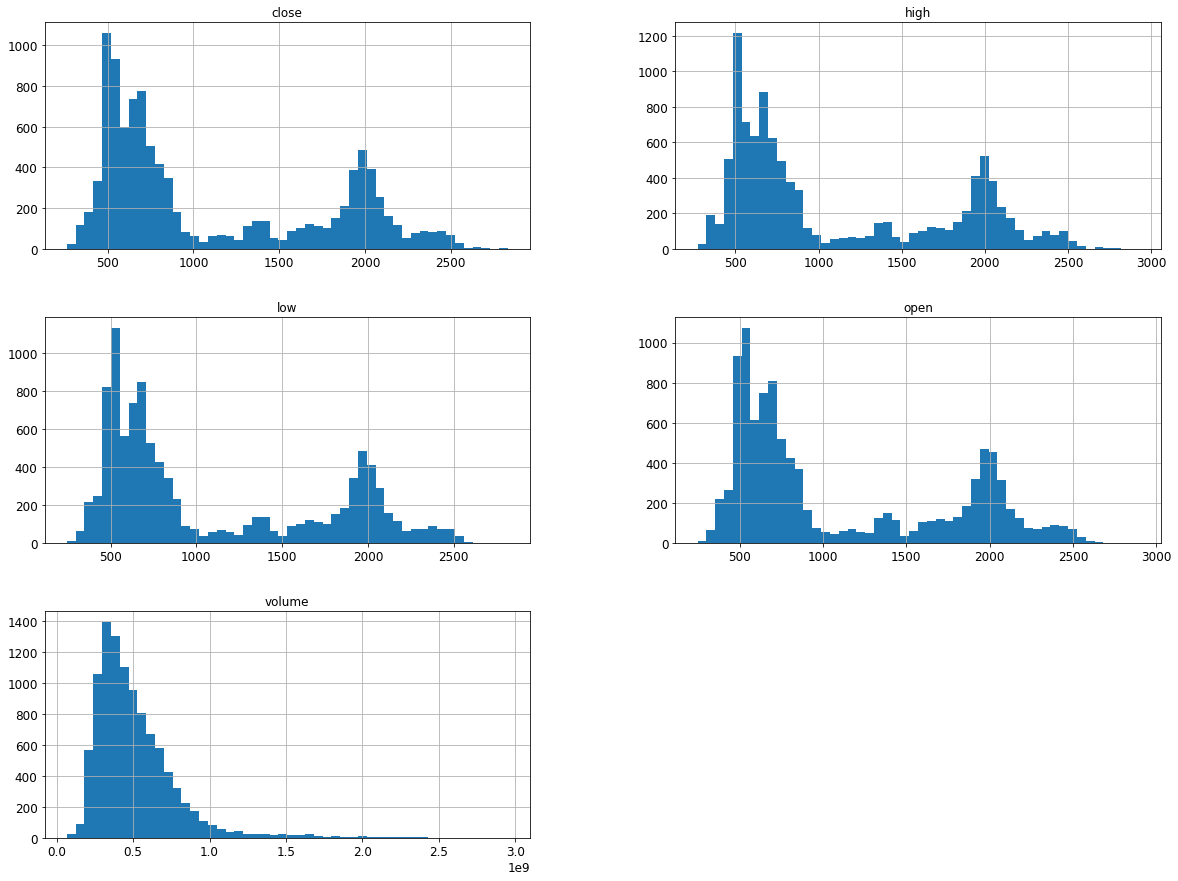

In [10]:
df4.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
display(df2, df4)

,itemname,date,open,high,low,close,volume
0,WI,2017-09-21,1104,1145,1024,1024,238155
1,WI,2019-07-03,1784,1814,1780,1792,57206
2,WI,2020-02-05,1820,1840,1780,1792,50494
3,WI,2016-03-07,2800,2908,2779,2816,690287
4,WI,2019-01-02,1849,1849,1754,1793,27881
...,...,...,...,...,...,...,...
2557905,피엔케이피부임상연구센타,2020-10-30,21800,23150,21750,22250,126879
2557906,피엔케이피부임상연구센타,2020-09-22,23500,23550,22150,22250,151167
2557907,피엔케이피부임상연구센타,2020-10-29,21950,22350,21300,21750,68232
2557908,피엔케이피부임상연구센타,2020-09-21,25400,25850,23400,23800,161173


,itemname,open,high,low,close,volume
date,,,,,,
2000-01-04,kospi,1028,1066,1016,1059,195899000
2000-01-05,kospi,1006,1047,984,986,257696000
2000-01-06,kospi,1013,1014,953,960,203524000
2000-01-07,kospi,949,970,930,948,215664000
2000-01-10,kospi,979,994,965,987,240175000
...,...,...,...,...,...,...
2020-11-16,kosdaq,843,849,841,847,1619880000
2020-11-17,kosdaq,846,846,836,839,1789493000
2020-11-18,kosdaq,842,852,840,851,2330367000


In [12]:
df1 = df1.set_index('itemname')
df3 = df3.set_index('itemname')
df2 = df2.sort_values(['itemname', 'date'])
df4 = df4.reset_index().sort_values(['itemname', 'date'])

In [13]:
nums = [5, 10, 20, 50, 120, 300]
for df in [df2, df4]:
    for n in nums:
        df[f'{n}dm'] = df.groupby('itemname')['close'].rolling(n).mean().reset_index(0, drop=True)
        df[f'{n}dmv'] = df.groupby('itemname')['volume'].rolling(n).mean().reset_index(0, drop=True)

In [14]:
for df in [df2, df4]:
    for i, x in enumerate(nums):
        for y in nums[i + 1:]:
            df[f'{x}dm/{y}dm'] = df[f'{x}dm'] / df[f'{y}dm']
            df[f'{x}dmv/{y}dmv'] = df[f'{x}dmv'] / df[f'{y}dmv']
    df = df.drop([f'{n}dm' for n in nums] + [f'{n}dmv' for n in nums], axis=1)
display(df2, df4)

,itemname,date,open,high,low,close,volume,5dm,5dmv,10dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
1870679,3S,2015-09-01,2115,2180,2050,2090,153694,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871464,3S,2015-09-02,2020,2095,2000,2080,147530,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1870598,3S,2015-09-03,2100,2185,2080,2125,200973,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1870705,3S,2015-09-04,2120,2175,2000,2040,192344,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1870734,3S,2015-09-07,2125,2125,2005,2045,78381,2076.0,154584.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361539,힘스,2020-11-16,13000,13200,12900,13100,177948,13150.0,175784.4,13125.0,...,1.041010,0.606278,1.125622,0.909347,1.036968,1.004658,1.121252,1.506870,1.081278,1.499884
361541,힘스,2020-11-17,13150,13200,12900,12950,129075,13100.0,176129.4,13120.0,...,1.035979,0.546769,1.120897,0.821485,1.036018,0.996986,1.120940,1.497907,1.081969,1.502436
361543,힘스,2020-11-18,12850,13050,12850,12900,105752,13050.0,174750.6,13105.0,...,1.030878,0.527963,1.116300,0.794862,1.034828,0.992371,1.120577,1.494040,1.082863,1.505525
361546,힘스,2020-11-19,13000,13250,12750,12850,134107,12950.0,161351.4,13070.0,...,1.026859,0.522036,1.112954,0.787322,1.034311,0.971742,1.121030,1.465558,1.083843,1.508175


,date,itemname,open,high,low,close,volume,5dm,5dmv,10dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
5157,2000-01-04,kosdaq,2583,2682,2528,2660,64950000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5158,2000-01-05,kosdaq,2561,2635,2532,2629,106351000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5159,2000-01-06,kosdaq,2670,2684,2396,2475,109938000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5160,2000-01-07,kosdaq,2301,2324,2249,2276,102454000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5161,2000-01-10,kosdaq,2363,2363,2184,2310,94752000,2470.0,9.568900e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5152,2020-11-16,kospi,2507,2546,2507,2543,1239135000,2489.6,1.265283e+09,2442.4,...,1.046788,1.037328,1.118951,1.249890,1.042476,1.022896,1.114342,1.232501,1.068938,1.204914
5153,2020-11-17,kospi,2544,2556,2533,2539,1267495000,2507.0,1.225949e+09,2462.0,...,1.048800,1.056747,1.122128,1.270659,1.042069,1.016944,1.114926,1.222800,1.069916,1.202426
5154,2020-11-18,kospi,2548,2553,2536,2545,923504000,2519.0,1.156242e+09,2480.8,...,1.050659,1.065402,1.125208,1.274608,1.041430,1.018060,1.115324,1.217970,1.070955,1.196364
5155,2020-11-19,kospi,2536,2548,2529,2547,976483000,2533.4,1.095800e+09,2494.2,...,1.052862,1.076299,1.128680,1.281251,1.041027,1.011563,1.115993,1.204187,1.072011,1.190423


In [70]:
df2 = df2.drop([f'{n}dm' for n in nums] + [f'{n}dmv' for n in nums], axis=1)
df4 = df4.drop([f'{n}dm' for n in nums] + [f'{n}dmv' for n in nums], axis=1)

In [73]:
display(
    df2.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))),
    df4.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))),
)

,open,high,low,close,volume,5dm/10dm,5dmv/10dmv,5dm/20dm,5dmv/20dmv,5dm/50dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
count,2.55791e+06,2.55791e+06,2.55791e+06,2.55791e+06,2.55791e+06,2.53752e+06,2.49569e+06,2.51491e+06,2.47741e+06,2.44732e+06,...,2.29268e+06,2.27301e+06,1.90287e+06,1.89634e+06,2.29268e+06,2.27301e+06,1.90287e+06,1.89634e+06,1.90287e+06,1.89634e+06
mean,22144.9,22537.8,21748,22247.5,658819,0.999838,0.991004,0.999977,1.00534,0.99984,...,0.997512,1.06434,0.976668,1.18862,0.99533,1.02158,0.974395,1.13128,0.974652,1.05827
std,65254.8,66219.4,64303,65264.7,4.07575e+06,0.0315895,0.325795,0.0657011,0.583328,0.120683,...,0.160254,0.839632,0.269807,1.39994,0.107218,0.452119,0.22906,0.903478,0.154111,0.497792
min,0,0,0,107,0,0.131771,0,0.0808313,0,0.0656879,...,0.0812008,0,0.064468,0,0.105719,0,0.0747422,0,0.10459,0
25%,2928,2997,2860,3000,27510,0.986276,0.782548,0.970064,0.641265,0.942202,...,0.9148,0.546029,0.833583,0.438624,0.937319,0.714258,0.849465,0.542287,0.88929,0.703562
50%,6350,6490,6210,6410,96856,0.999433,0.969253,0.998058,0.883289,0.992867,...,0.984781,0.84437,0.942918,0.775873,0.989853,0.963715,0.948548,0.879091,0.964107,0.98223
75%,16150,16500,15800,16250,325719,1.01192,1.17334,1.02503,1.2017,1.04443,...,1.05779,1.27303,1.06656,1.34182,1.04181,1.26873,1.05845,1.40624,1.04325,1.35302
max,1.749e+06,1.749e+06,1.692e+06,1.749e+06,8.51967e+08,1.86857,2,3.37158,4,6.64668,...,4.70297,6,6.99224,15,2.22585,2.4,4.28942,6,2.16804,2.5


,open,high,low,close,volume,5dm/10dm,5dmv/10dmv,5dm/20dm,5dmv/20dmv,5dm/50dm,...,20dm/120dm,20dmv/120dmv,20dm/300dm,20dmv/300dmv,50dm/120dm,50dmv/120dmv,50dm/300dm,50dmv/300dmv,120dm/300dm,120dmv/300dmv
count,10314,10314,10314,10314,10314,10296,10296,10276,10276,10216,...,10076,10076,9716,9716,10076,10076,9716,9716,9716,9716
mean,1107.09,1114.02,1097.58,1105.85,5.11798e+08,0.999984,1.00109,1.00024,1.00493,1.00067,...,1.00315,1.02092,1.01822,1.04901,1.00089,1.01239,1.01464,1.04134,1.00694,1.02605
std,653.937,657.102,650.021,653.843,2.73765e+08,0.0165306,0.0749875,0.0334572,0.127322,0.0624753,...,0.0900198,0.192211,0.139144,0.283235,0.0643644,0.125989,0.12543,0.238039,0.093938,0.162631
min,247,272,245,261,6.495e+07,0.859688,0.705104,0.784225,0.596974,0.637515,...,0.651151,0.579575,0.503408,0.468935,0.744715,0.679352,0.551518,0.498895,0.567207,0.654364
25%,565,568,560,564,3.31748e+08,0.992804,0.952716,0.985763,0.921582,0.971157,...,0.96263,0.884137,0.950842,0.826931,0.973153,0.921268,0.95677,0.851044,0.969424,0.899309
50%,764,770,756,763,4.46804e+08,1.00148,1.00009,1.00328,0.997918,1.00579,...,1.00933,1.00394,1.01668,1.01171,1.00614,1.00457,1.01392,1.01191,1.00715,1.0076
75%,1839,1851,1817.75,1838,6.18540e+08,1.00872,1.04824,1.01845,1.07872,1.03703,...,1.05153,1.13902,1.10054,1.23692,1.03483,1.09955,1.09463,1.22381,1.06114,1.15333
max,2894,2925,2815,2834,2.95168e+09,1.10532,1.36236,1.18536,1.71938,1.23485,...,1.30751,1.90955,1.46405,2.4499,1.19165,1.47069,1.3693,1.75094,1.21962,1.44608


In [16]:
df2  = df2.set_index('itemname')

In [204]:
import arrow
date = arrow.get('2018-01-02')
df = pd.DataFrame()
while date < arrow.get('2020-08-23'):
    date_str = date.format('YYYY-MM-DD')
    date2 = df1[df1.date >= date.shift(months=3).format('YYYY-MM-DD')].date.min()
    print(date_str, date2)
    temp = df1[df1.date == date_str]
    temp2 = df2[df2.date == date_str]
    temp['ror'] = df2[df2.date == date2].close / temp2.close
    temp = temp.reset_index().set_index(['itemname', 'date'])
    temp2 = temp2.reset_index().set_index(['itemname', 'date']).drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
    temp = temp.join(temp2, how='inner')
    temp = temp.reset_index().set_index('itemname')
    temp[['market', 'sector', 'area']] = df3[['market', 'sector', 'area']]
    temp4 = df4[df4.date == date_str].set_index(['itemname', 'date'])\
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1).add_suffix('_market')
    temp = temp.reset_index().merge(temp4, left_on=['market', 'date'], right_on=['itemname', 'date'], how='left')
    df = df.append(temp)
    date = arrow.get(df1[df1.date >= date.shift(months=1, days=-1).format('YYYY-MM-DD')].date.min())
df

2018-01-02 2018-04-02 00:00:00


C:\Users\gsr27\Anaconda3\envs\ml_lab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2018-02-01 2018-05-02 00:00:00
2018-02-28 2018-05-28 00:00:00
2018-03-27 2018-06-27 00:00:00
2018-04-26 2018-07-26 00:00:00
2018-05-25 2018-08-27 00:00:00
2018-06-25 2018-09-27 00:00:00
2018-07-24 2018-10-24 00:00:00
2018-08-23 2018-11-23 00:00:00
2018-09-27 2018-12-27 00:00:00
2018-10-26 2019-01-28 00:00:00
2018-11-26 2019-02-26 00:00:00
2018-12-26 2019-03-26 00:00:00
2019-01-25 2019-04-25 00:00:00
2019-02-25 2019-05-27 00:00:00
2019-03-25 2019-06-25 00:00:00
2019-04-24 2019-07-24 00:00:00
2019-05-23 2019-08-23 00:00:00
2019-06-24 2019-09-24 00:00:00
2019-07-23 2019-10-23 00:00:00
2019-08-22 2019-11-22 00:00:00
2019-09-23 2019-12-23 00:00:00
2019-10-22 2020-01-22 00:00:00
2019-11-21 2020-02-21 00:00:00
2019-12-20 2020-03-20 00:00:00
2020-01-20 2020-04-20 00:00:00
2020-02-19 2020-05-19 00:00:00
2020-03-18 2020-06-18 00:00:00
2020-04-17 2020-07-17 00:00:00
2020-05-18 2020-08-18 00:00:00
2020-06-17 2020-09-17 00:00:00
2020-07-16 2020-10-16 00:00:00
2020-08-18 2020-11-18 00:00:00


,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dm/120dm_market,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market
0,키다리스튜디오,2018-01-02,-19.155,2.613,-23.652,3.016,-13.47,-10.27,-2.203,-3.030,...,1.011887,1.012802,1.094537,0.901986,1.025422,1.126849,1.109178,1.003555,1.081679,0.890585
1,조이시티,2018-01-02,-14.154,2.771,-20.814,1.764,-29.01,-20.99,-5.336,-7.965,...,1.109710,1.515779,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059
2,대한제분,2018-01-02,5.496,0.393,3.779,0.346,7.44,5.86,4.144,5.096,...,1.011887,1.012802,1.094537,0.901986,1.025422,1.126849,1.109178,1.003555,1.081679,0.890585
3,고려제약,2018-01-02,16.972,1.387,14.094,1.435,8.47,7.19,7.934,9.298,...,1.109710,1.515779,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059
4,한스바이오메드,2018-01-02,41.499,5.886,34.287,8.317,15.57,11.23,11.845,17.273,...,1.109710,1.515779,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,율촌화학,2020-08-18,15.490,1.144,14.576,1.528,7.44,4.16,3.773,6.655,...,1.137280,0.971428,1.113518,1.259182,1.091686,0.956106,1.068877,1.239323,0.979107,1.296218
1721,이랜텍,2020-08-18,-2.929,0.724,-29.325,0.397,-24.87,-8.11,-1.021,-3.279,...,1.191981,0.998177,1.232993,1.307668,1.130345,0.958469,1.169236,1.255648,1.034407,1.310056
1722,현대위아,2020-08-18,-5.727,0.343,7.016,0.387,-6.16,-2.92,-2.340,-4.957,...,1.137280,0.971428,1.113518,1.259182,1.091686,0.956106,1.068877,1.239323,0.979107,1.296218
1723,청보산업,2020-08-18,0.000,1.630,16.000,1.627,1.42,0.80,0.000,0.000,...,1.191981,0.998177,1.232993,1.307668,1.130345,0.958469,1.169236,1.255648,1.034407,1.310056


In [205]:
df['month'] = df['date'].dt.month.astype(str)

In [76]:
df.describe()

,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,20dm/120dm_market,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market
count,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,55725.000000,...,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000,55294.000000
mean,12.602588,1.623592,10.556827,2.171885,2.229250,1.955234,3.532024,5.911689,29.350324,0.200343,...,1.001774,1.079271,0.997707,1.168697,0.999919,1.057020,0.995842,1.147428,0.994609,1.083971
std,71.952039,1.714381,75.136996,5.665559,19.695484,9.111005,6.998552,14.827973,70.217372,0.212238,...,0.076784,0.196043,0.116433,0.263648,0.052848,0.130693,0.101502,0.220654,0.067919,0.148056
min,-704.016000,0.002000,-1012.000000,0.000000,-162.140000,-48.460000,-25.532000,-183.333000,0.000000,-1.054000,...,0.850601,0.616403,0.825638,0.682924,0.904970,0.712086,0.860862,0.724378,0.899344,0.749795
25%,-2.225000,0.653000,3.592000,0.413000,-1.600000,-0.830000,0.000000,0.000000,7.200000,0.089000,...,0.939223,0.957431,0.922101,1.037760,0.961575,0.989634,0.925960,1.003555,0.946246,0.987059
50%,9.038000,1.075000,8.436000,0.918000,4.610000,2.600000,3.189000,5.797000,11.550000,0.150000,...,0.995659,1.074542,0.954537,1.135897,0.996189,1.074656,0.959065,1.154367,0.975850,1.102749
75%,21.296000,1.955000,17.629000,2.056000,10.550000,6.180000,6.762000,12.693000,22.920000,0.239000,...,1.040138,1.218618,1.046714,1.342756,1.025422,1.158087,1.032732,1.283158,1.034407,1.208974
max,735.417000,21.875000,1025.000000,411.875000,145.940000,50.590000,31.667000,196.283000,1241.340000,3.235000,...,1.203313,1.515779,1.313648,1.769619,1.130345,1.311205,1.246263,1.563798,1.157774,1.330031


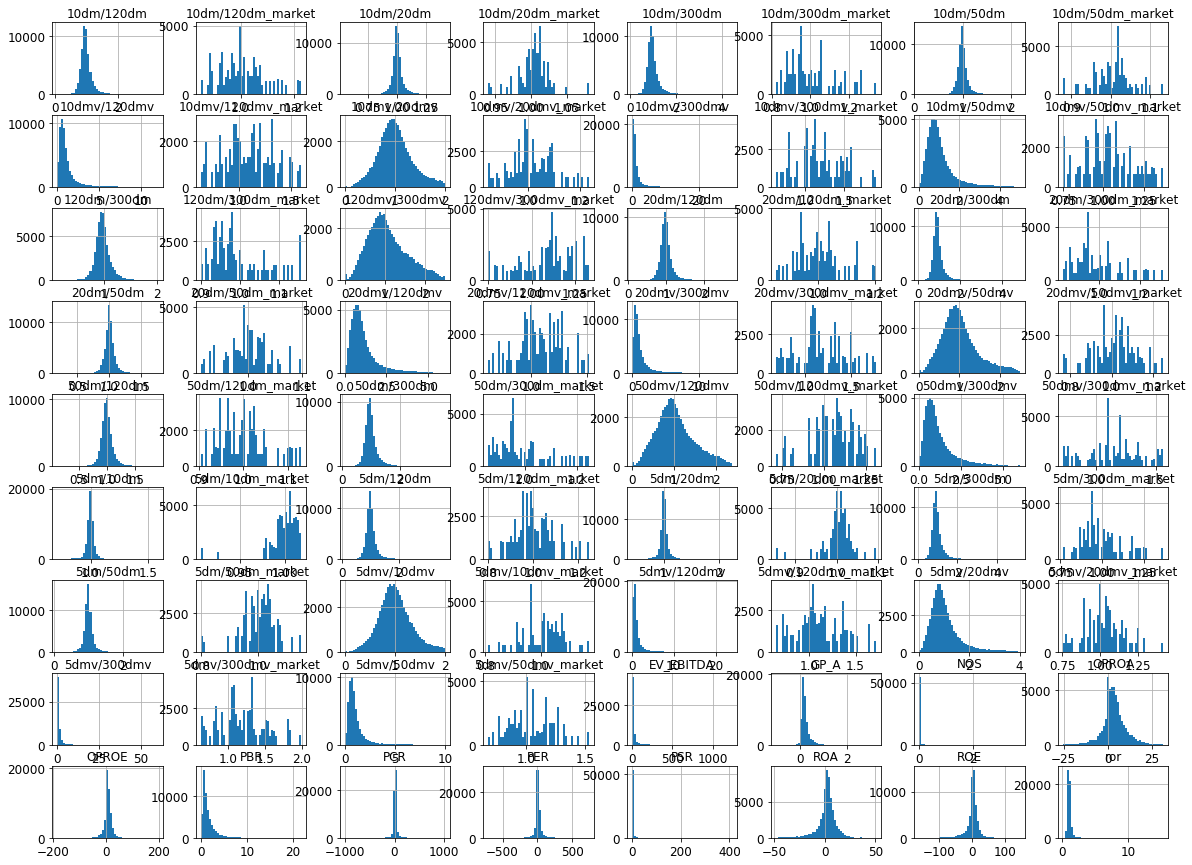

In [78]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [206]:
df.isnull().sum()

itemname                  0
date                      0
PER                       0
PBR                       0
PCR                       0
                       ... 
50dm/300dm_market       431
50dmv/300dmv_market     431
120dm/300dm_market      431
120dmv/300dmv_market    431
month                     0
Length: 78, dtype: int64

In [207]:
df = df.dropna()
df.isnull().sum()

itemname                0
date                    0
PER                     0
PBR                     0
PCR                     0
                       ..
50dm/300dm_market       0
50dmv/300dmv_market     0
120dm/300dm_market      0
120dmv/300dmv_market    0
month                   0
Length: 78, dtype: int64

In [21]:
df['PER_rank'] = df.PER.rank()
df['PBR_rank'] = df.PBR.rank()
df['PSR_rank'] = df.PSR.rank()
df['ROE_rank'] = df.ROE.rank(ascending=False)
df['ROA_rank'] = df.ROA.rank(ascending=False)
df['OPROE_rank'] = df.OPROE.rank(ascending=False)
df['OPROA_rank'] = df.OPROA.rank(ascending=False)
df['GP_A_rank'] = df.GP_A.rank(ascending=False)
df['final_rank'] = df['PBR_rank'] + df['ROE_rank'] + df['OPROE_rank']
df

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,area,PER_rank,PBR_rank,PSR_rank,ROE_rank,ROA_rank,OPROE_rank,OPROA_rank,GP_A_rank,final_rank
24648,0,메타바이오메드,2019-04-11,-44.306,1.477,32.551,1.415,-3.54,-1.97,-0.401,...,충청북도,1400.0,17830.0,16631.0,20157.5,20350.5,20655.0,20580.0,8780.0,58642.5
24649,1,남해화학,2019-04-11,70.833,1.368,26.211,0.476,1.97,1.51,3.103,...,서울특별시,24953.0,17014.0,7629.0,15903.5,15033.5,13741.0,12035.0,9175.5,46658.5
24650,2,해태제과식품,2019-04-11,-69.079,0.945,9.868,0.421,-1.54,-0.55,0.877,...,충청남도,945.0,12601.5,6741.5,19163.0,18830.5,15440.5,16479.5,4014.5,47205.0
24651,3,희림,2019-04-11,34.714,1.145,11.489,0.399,3.78,1.38,2.751,...,서울특별시,23089.0,14998.0,6393.5,13608.5,15343.5,9854.0,12685.0,8240.0,38460.5
24653,5,우수AMS,2019-04-11,19.492,1.852,10.624,0.466,9.67,3.53,4.573,...,경상남도,20394.0,20235.0,7468.0,7213.0,10689.5,6326.0,9231.0,13381.5,33774.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52350,1716,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,...,충청북도,25410.0,13939.5,18837.5,16858.5,16483.0,20786.0,20844.5,24508.0,51584.0
52351,1717,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,...,서울특별시,2337.0,18519.5,25717.0,21394.0,22928.0,23928.0,25041.0,26194.5,63841.5
52352,1718,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,...,서울특별시,10216.0,5076.0,2528.5,1443.0,9561.5,387.0,5922.0,15593.0,6906.0
52353,1719,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,...,경기도,5903.0,5552.0,10202.0,22838.0,24035.0,24589.0,25438.0,26219.5,52979.0


In [22]:
df.columns

Index(['index', 'itemname', 'date', 'PER', 'PBR', 'PCR', 'PSR', 'ROE', 'ROA',
       'OPROA', 'OPROE', 'EV_EBITDA', 'GP_A', 'NOS', 'ror', '5dm/10dm',
       '5dmv/10dmv', '5dm/20dm', '5dmv/20dmv', '5dm/50dm', '5dmv/50dmv',
       '5dm/120dm', '5dmv/120dmv', '5dm/300dm', '5dmv/300dmv', '10dm/20dm',
       '10dmv/20dmv', '10dm/50dm', '10dmv/50dmv', '10dm/120dm', '10dmv/120dmv',
       '10dm/300dm', '10dmv/300dmv', '20dm/50dm', '20dmv/50dmv', '20dm/120dm',
       '20dmv/120dmv', '20dm/300dm', '20dmv/300dmv', '50dm/120dm',
       '50dmv/120dmv', '50dm/300dm', '50dmv/300dmv', '120dm/300dm',
       '120dmv/300dmv', 'market', 'sector', 'area', 'PER_rank', 'PBR_rank',
       'PSR_rank', 'ROE_rank', 'ROA_rank', 'OPROE_rank', 'OPROA_rank',
       'GP_A_rank', 'final_rank'],
      dtype='object')

In [23]:
df['quantile'] = pd.qcut(df['final_rank'], 30, labels=False)
df

C:\Users\gsr27\Anaconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,...,PER_rank,PBR_rank,PSR_rank,ROE_rank,ROA_rank,OPROE_rank,OPROA_rank,GP_A_rank,final_rank,quantile
24648,0,메타바이오메드,2019-04-11,-44.306,1.477,32.551,1.415,-3.54,-1.97,-0.401,...,1400.0,17830.0,16631.0,20157.5,20350.5,20655.0,20580.0,8780.0,58642.5,25
24649,1,남해화학,2019-04-11,70.833,1.368,26.211,0.476,1.97,1.51,3.103,...,24953.0,17014.0,7629.0,15903.5,15033.5,13741.0,12035.0,9175.5,46658.5,20
24650,2,해태제과식품,2019-04-11,-69.079,0.945,9.868,0.421,-1.54,-0.55,0.877,...,945.0,12601.5,6741.5,19163.0,18830.5,15440.5,16479.5,4014.5,47205.0,20
24651,3,희림,2019-04-11,34.714,1.145,11.489,0.399,3.78,1.38,2.751,...,23089.0,14998.0,6393.5,13608.5,15343.5,9854.0,12685.0,8240.0,38460.5,15
24653,5,우수AMS,2019-04-11,19.492,1.852,10.624,0.466,9.67,3.53,4.573,...,20394.0,20235.0,7468.0,7213.0,10689.5,6326.0,9231.0,13381.5,33774.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52350,1716,보성파워텍,2020-07-22,93.750,1.045,26.786,1.884,1.19,0.79,-0.643,...,25410.0,13939.5,18837.5,16858.5,16483.0,20786.0,20844.5,24508.0,51584.0,23
52351,1717,에코바이오,2020-07-22,-24.326,1.570,75.965,13.282,-6.40,-5.78,-8.779,...,2337.0,18519.5,25717.0,21394.0,22928.0,23928.0,25041.0,26194.5,63841.5,27
52352,1718,한라,2020-07-22,2.200,0.515,3.594,0.200,24.50,4.08,6.915,...,10216.0,5076.0,2528.5,1443.0,9561.5,387.0,5922.0,15593.0,6906.0,0
52353,1719,유아이엘,2020-07-22,-4.578,0.539,38.148,0.664,-11.91,-9.14,-10.790,...,5903.0,5552.0,10202.0,22838.0,24035.0,24589.0,25438.0,26219.5,52979.0,23


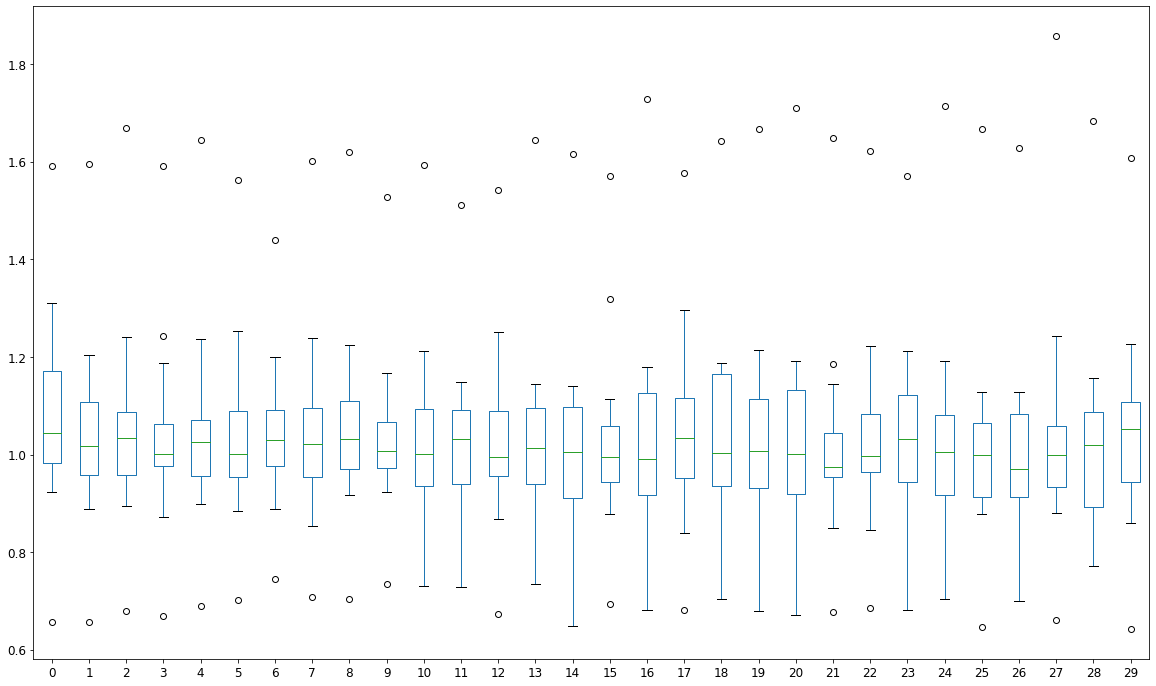

In [24]:
pd.DataFrame(df.groupby(['date', 'quantile'])['ror'].mean()).reset_index().pivot(index='date', columns='quantile', values='ror').plot.box(figsize=(20,12))

In [81]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [82]:
test_set.head()

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month
823,한일사료,2019-03-25,211.111,1.208,30.645,0.243,0.56,0.23,1.210,3.387,...,1.237017,0.942523,1.037760,1.022123,1.166616,0.919240,0.978699,0.899344,0.838922,3
416,율호,2020-03-18,0.000,2.186,-33.095,0.784,-9.34,-1.66,0.000,0.000,...,1.277989,0.898781,1.487987,1.000497,1.167152,0.957417,1.358938,0.956941,1.164319,3
412,에스텍,2020-04-17,8.547,0.587,34.189,1.347,7.47,5.44,3.793,5.165,...,1.415003,0.842567,1.736351,0.947689,1.253055,0.898818,1.537624,0.948431,1.227100,4
1235,캠시스,2018-08-23,-3.472,1.861,-6.599,0.280,-44.98,-13.46,5.347,20.852,...,0.667498,1.005572,0.708330,0.949554,0.755733,1.032732,0.801962,1.087596,1.061171,8
412,애니젠,2018-11-26,156.593,2.972,46.117,15.489,1.91,1.80,1.181,1.255,...,0.913193,0.860561,0.727443,0.942444,0.909346,0.925960,0.724378,0.982509,0.796592,11


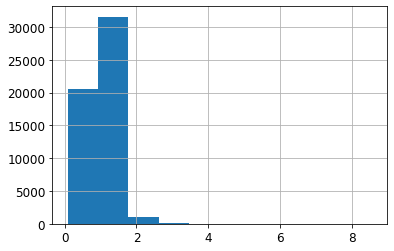

In [83]:
df["ror"].hist()

In [84]:
df["ror_cat"] = pd.cut(df["ror"], bins=[0., 0.6, 0.9, 1.1, 1.5, np.inf], labels=[1, 2, 3, 4, 5])

C:\Users\gsr27\Anaconda3\envs\ml_lab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df["ror_cat"].value_counts()

3    21743
2    15883
4    11624
5     2808
1     1274
Name: ror_cat, dtype: int64

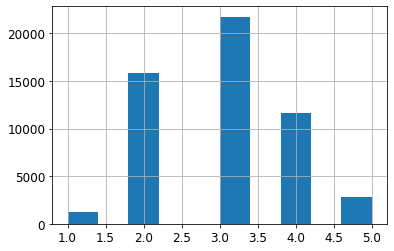

In [86]:
df["ror_cat"].hist()

In [87]:
df = df.reset_index(drop=True)
df

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month,ror_cat
0,키다리스튜디오,2018-01-02,-19.155,2.613,-23.652,3.016,-13.47,-10.27,-2.203,-3.030,...,1.094537,0.901986,1.025422,1.126849,1.109178,1.003555,1.081679,0.890585,1,4
1,조이시티,2018-01-02,-14.154,2.771,-20.814,1.764,-29.01,-20.99,-5.336,-7.965,...,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059,1,4
2,대한제분,2018-01-02,5.496,0.393,3.779,0.346,7.44,5.86,4.144,5.096,...,1.094537,0.901986,1.025422,1.126849,1.109178,1.003555,1.081679,0.890585,1,3
3,고려제약,2018-01-02,16.972,1.387,14.094,1.435,8.47,7.19,7.934,9.298,...,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059,1,5
4,한스바이오메드,2018-01-02,41.499,5.886,34.287,8.317,15.57,11.23,11.845,17.273,...,1.177100,1.496163,1.077600,1.213257,1.143041,1.197557,1.060728,0.987059,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53327,율촌화학,2020-08-18,15.490,1.144,14.576,1.528,7.44,4.16,3.773,6.655,...,1.113518,1.259182,1.091686,0.956106,1.068877,1.239323,0.979107,1.296218,8,3
53328,이랜텍,2020-08-18,-2.929,0.724,-29.325,0.397,-24.87,-8.11,-1.021,-3.279,...,1.232993,1.307668,1.130345,0.958469,1.169236,1.255648,1.034407,1.310056,8,4
53329,현대위아,2020-08-18,-5.727,0.343,7.016,0.387,-6.16,-2.92,-2.340,-4.957,...,1.113518,1.259182,1.091686,0.956106,1.068877,1.239323,0.979107,1.296218,8,4
53330,청보산업,2020-08-18,0.000,1.630,16.000,1.627,1.42,0.80,0.000,0.000,...,1.232993,1.307668,1.130345,0.958469,1.169236,1.255648,1.034407,1.310056,8,5


In [88]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["ror_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [89]:
strat_test_set["ror_cat"].value_counts() / len(strat_test_set)

3    0.407706
2    0.297834
4    0.217962
5    0.052592
1    0.023906
Name: ror_cat, dtype: float64

In [90]:
df["ror_cat"].value_counts() / len(df)

3    0.407691
2    0.297814
4    0.217955
5    0.052651
1    0.023888
Name: ror_cat, dtype: float64

In [91]:
def income_cat_proportions(data):
    return data["ror_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [92]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.023888,0.023906,0.023531,-1.496907,0.072864
2,0.297814,0.297834,0.298397,0.195837,0.006967
3,0.407691,0.407706,0.411643,0.969347,0.003573
4,0.217955,0.217962,0.215337,-1.201359,0.002978
5,0.052651,0.052592,0.051092,-2.961299,-0.112456


In [93]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("ror_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [94]:
tdf = strat_train_set.copy()
tdf

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month
44688,부국철강,2020-03-18,0.000,0.446,22.411,0.380,1.64,1.49,0.000,0.000,...,1.328401,0.931842,1.488504,0.999328,1.214002,1.001497,1.360318,1.002170,1.120523,3
4241,아이에이네트웍스,2018-02-28,-6.679,1.882,-62.500,1.511,-28.41,-12.91,-14.220,-29.808,...,1.074542,1.265321,1.198045,1.109742,1.225550,1.235558,1.366409,1.113375,1.114936,2
13097,대림제지,2018-08-23,27.072,0.673,10.757,0.747,2.85,1.81,2.094,3.840,...,0.667498,1.005572,0.708330,0.949554,0.755733,1.032732,0.801962,1.087596,1.061171,8
36878,이엠코리아,2019-11-21,-4.987,1.746,29.922,1.295,-33.55,-13.70,-9.600,-23.762,...,1.231688,0.947624,1.373418,0.992144,1.084678,0.928412,1.209491,0.935763,1.115069,11
31673,조비,2019-07-23,334.921,2.270,77.289,1.810,0.69,0.35,2.021,3.934,...,1.083774,0.952386,1.194158,0.971711,1.153846,0.948244,1.271367,0.975850,1.101852,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25658,SGA,2019-04-24,-4.754,1.199,-40.962,0.579,-27.91,-11.97,-5.787,-10.658,...,1.181827,0.963012,1.100538,1.049975,1.158087,0.955904,1.078431,0.910406,0.931217,4
51124,푸드나무,2020-07-16,31.752,3.617,72.949,3.617,11.82,9.59,11.480,14.532,...,0.957431,1.144749,1.273413,1.105974,1.009397,1.111433,1.342529,1.004935,1.330031,7
35432,경인전자,2019-10-22,60.598,0.596,-168.939,1.897,1.06,1.01,-2.087,-2.194,...,0.873167,0.969328,1.060384,0.978460,0.905796,0.945929,1.100009,0.966753,1.214412,10
27175,와이제이엠게임즈,2019-05-23,-18.348,1.442,-8.155,2.373,-7.81,-5.40,-4.923,-7.295,...,1.123942,0.943834,1.111489,1.030703,1.101390,0.959089,1.089186,0.930519,0.988920,5


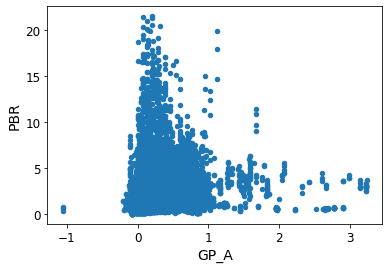

In [95]:
tdf.plot(kind="scatter", x="GP_A", y="PBR")

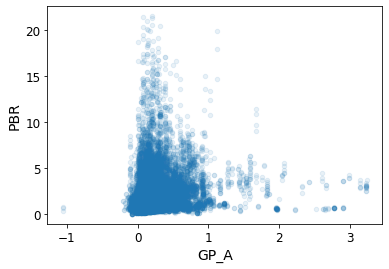

In [96]:
tdf.plot(kind="scatter", x="GP_A", y="PBR", alpha=0.1)

`sharex=False` 매개변수는 x-축의 값과 범례를 표시하지 못하는 버그를 수정합니다. 이는 임시 방편입니다(https://github.com/pandas-dev/pandas/issues/10611 참조). 수정 사항을 알려준 Wilmer Arellano에게 감사합니다.

In [97]:
corr_matrix = df.corr()

In [98]:
corr_matrix["ror"].sort_values(ascending=False)

ror                    1.000000
20dmv/300dmv_market    0.139972
20dmv/120dmv_market    0.135745
50dmv/120dmv_market    0.124475
50dmv/300dmv_market    0.113505
                         ...   
5dm/20dm              -0.118002
10dmv/20dmv_market    -0.121903
5dm/20dm_market       -0.152683
5dm/10dm              -0.167922
5dm/10dm_market       -0.231753
Name: ror, Length: 72, dtype: float64

In [99]:
피어슨의 상관 계수(위키백과):
![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

SyntaxError: invalid syntax (<ipython-input-99-2010d0096813>, line 1)

[0, 4, 0, 6]

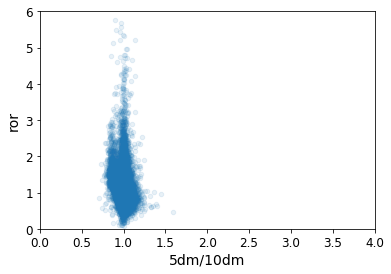

In [100]:
df.plot(kind="scatter", x="5dm/10dm", y="ror", alpha=0.1)
plt.axis([0, 4, 0, 6])

# 머신러닝 알고리즘을 위한 데이터 준비

In [101]:
tdf = strat_train_set.drop("ror", axis=1) # 훈련 세트를 위해 레이블 삭제
tdf_labels = strat_train_set["ror"].copy()

In [102]:
sample_incomplete_rows = tdf[tdf.isnull().any(axis=1)].head()
sample_incomplete_rows

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [ ]:
sample_incomplete_rows

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [ ]:
housing_num.median().values

훈련 세트를 변환합니다:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
imputer.strategy

In [ ]:
housing_tr.head()

이제 범주형 입력 특성인 `ocean_proximity`을 전처리합니다:

In [103]:
tdf_cat = tdf[["market"]]
tdf_cat.head(10)

,market
44688,kospi
4241,kosdaq
13097,kosdaq
36878,kosdaq
31673,kospi
8961,kosdaq
17403,kospi
51121,kospi
30693,kosdaq
33787,kospi


In [104]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
tdf_cat = ordinal_encoder.fit_transform(tdf_cat)
tdf_cat[:10]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [105]:
ordinal_encoder.categories_

[array(['kosdaq', 'kospi'], dtype=object)]

In [106]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
tdf_cat_1hot = cat_encoder.fit_transform(tdf_cat)
tdf_cat_1hot

<42665x2 sparse matrix of type '<class 'numpy.float64'>'
	with 42665 stored elements in Compressed Sparse Row format>

`OneHotEncoder`는 기본적으로 희소 행렬을 반환합니다. 필요하면 `toarray()` 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [107]:
tdf_cat_1hot.toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

또는 `OneHotEncoder`를 만들 때 `sparse=False`로 지정할 수 있습니다:

In [108]:
cat_encoder = OneHotEncoder(sparse=False)
tdf_cat_1hot = cat_encoder.fit_transform(tdf_cat)
tdf_cat_1hot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [109]:
cat_encoder.categories_

[array([0., 1.])]

추가 특성을 위해 사용자 정의 변환기를 만들어보죠:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [110]:
tdf = tdf.set_index(['itemname', 'date'])
tdf_num = tdf.drop(["market", "sector", "area", "month"], axis=1)

In [111]:
tdf_num.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42665 entries, (부국철강, 2020-03-18 00:00:00) to (대우조선해양, 2019-07-23 00:00:00)
Data columns (total 71 columns):
PER                     42665 non-null float64
PBR                     42665 non-null float64
PCR                     42665 non-null float64
PSR                     42665 non-null float64
ROE                     42665 non-null float64
ROA                     42665 non-null float64
OPROA                   42665 non-null float64
OPROE                   42665 non-null float64
EV_EBITDA               42665 non-null float64
GP_A                    42665 non-null float64
NOS                     42665 non-null float64
5dm/10dm                42665 non-null float64
5dmv/10dmv              42665 non-null float64
5dm/20dm                42665 non-null float64
5dmv/20dmv              42665 non-null float64
5dm/50dm                42665 non-null float64
5dmv/50dmv              42665 non-null float64
5dm/120dm               42665 non-null flo

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

tdf_num_tr = num_pipeline.fit_transform(tdf_num)

In [113]:
tdf_num_tr

array([[-1.76975854e-01, -6.79993020e-01,  1.54313856e-01, ...,
         9.65569159e-01,  1.07995589e-01,  2.47566707e-01],
       [-2.69603241e-01,  1.88408359e-01, -9.61271826e-01, ...,
         9.93147871e-01,  1.74990741e+00,  2.09834207e-01],
       [ 1.98470862e-01, -5.42717872e-01,  1.20017769e-03, ...,
        -1.56248234e+00,  1.36929863e+00, -1.53228976e-01],
       ...,
       [ 6.63424565e-01, -5.89282570e-01, -2.35969870e+00, ...,
        -2.13022802e-01, -4.14928773e-01,  8.81583798e-01],
       [-4.31434201e-01, -7.76756291e-02, -2.47271239e-01, ...,
        -2.62027320e-01, -9.49915451e-01, -6.41132273e-01],
       [-9.83556032e-02, -4.73777930e-01, -5.00523072e-02, ...,
         5.62830124e-01, -2.80616863e-01,  1.21480418e-01]])

In [174]:
from sklearn.compose import ColumnTransformer

num_attribs = list(tdf_num)
cat_attribs = ["market", "sector", "area", "month"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

tdf_prepared = full_pipeline.fit_transform(tdf)

In [175]:
tdf_prepared

<42665x251 sparse matrix of type '<class 'numpy.float64'>'
	with 3199875 stored elements in Compressed Sparse Row format>

In [176]:
tdf_prepared.shape

(42665, 251)

다음은 (판다스 `DataFrame` 열의 일부를 선택하기 위해) `DataFrameSelector` 변환기와 `FeatureUnion`를 사용한 예전 방식입니다:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

`ColumnTransformer`의 결과와 동일합니다:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# 모델 선택과 훈련

In [117]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(tdf_prepared, tdf_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [118]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = tdf.iloc[:5]
some_labels = tdf_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [1.41383849 1.06371422 1.00785005 1.0606953  1.02346009]


실제 값과 비교합니다:

In [119]:
print("레이블:", list(some_labels))

레이블: [1.6434262948207172, 1.2045714285714286, 0.8928571428571429, 1.0208877284595301, 0.8104265402843602]


In [120]:
some_data_prepared

<5x251 sparse matrix of type '<class 'numpy.float64'>'
	with 375 stored elements in Compressed Sparse Row format>

In [121]:
from sklearn.metrics import mean_squared_error

tdf_predictions = lin_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.27915733338705395

In [122]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.1662871664881351

In [182]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(random_state=42)
mlp_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = mlp_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.19609143314991978

In [183]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.1329943309785314

In [208]:
date = '2020-11-20'
temp = df2[df2.date == date].drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
pdf = pd.merge(df1[df1.date == date], temp, left_index=True, right_index=True, how='inner')
pdf = pdf.rename(columns={'date_x': 'date'})
pdf[['market', 'sector', 'area']] = df3[['market', 'sector', 'area']]
temp4 = df4[df4.date == date].set_index(['itemname', 'date'])\
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1).add_suffix('_market')
pdf = pdf.reset_index().merge(temp4, left_on=['market', 'date'], right_on=['itemname', 'date'], how='left')
pdf['month'] = pdf['date'].dt.month.astype(str)
pdf = pdf.set_index(['itemname', 'date']).dropna()
pdf = pdf.drop('date_y', axis=1)
pdf

,,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,20dmv/120dmv_market,20dm/300dm_market,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month
itemname,date,,,,,,,,,,,,,,,,,,,,,
아난티,2020-11-20,-15.125,2.070,-34.571,16.479,-13.52,-4.91,-2.524,-6.780,39.90,0.024,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
서흥,2020-11-20,11.654,1.650,8.267,1.330,15.02,7.30,10.157,21.375,9.51,0.158,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
보성파워텍,2020-11-20,103.750,1.157,29.643,2.085,1.19,0.79,-0.643,-0.972,66.66,0.032,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
화천기공,2020-11-20,-25.000,0.233,7.368,0.586,-0.94,-0.74,-1.270,-1.615,8.17,0.043,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
코다코,2020-11-20,-1.420,2.201,-5.896,0.549,-154.21,-10.30,-5.870,-97.959,20.55,0.017,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
이아이디,2020-11-20,-5.176,1.498,-58.667,2.186,-28.73,-17.43,0.518,0.868,30.24,0.081,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
에이프로젠 H&G,2020-11-20,6.092,0.593,27.074,24.367,9.97,9.64,-0.887,-0.912,520.21,0.012,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
와이솔,2020-11-20,118.561,1.271,110.993,2.803,1.11,0.97,1.399,1.648,4.68,0.137,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11


In [185]:
pdf_prepared = full_pipeline.transform(pdf)
pdf_prepared

<1584x251 sparse matrix of type '<class 'numpy.float64'>'
	with 118800 stored elements in Compressed Sparse Row format>

In [ ]:
pdf_prepared.shape

In [ ]:
pdf_predictions = mlp_reg.predict(pdf_prepared)
pdf_predictions

In [ ]:
pdf['pred_ror'] = pdf_predictions
pdf['pred_ror_rank'] = pdf['pred_ror'].rank(ascending=False)
pdf = pdf.sort_values('pred_ror_rank')
pdf.head(30)

In [ ]:
pdf.head(30)[['market', 'sector', 'area']]

In [ ]:
pdf = pdf.reset_index()

In [ ]:
df.columns = df.columns.str.replace('/', '')
pdf.columns = pdf.columns.str.replace('/', '')

In [ ]:
import string
na_map = dict(enumerate(string.ascii_lowercase))
for i in range(10):
    df.columns = df.columns.str.replace(f'{i}', na_map[i])
    pdf.columns = pdf.columns.str.replace(f'{i}', na_map[i])
df.columns, pdf.columns

In [ ]:
pdf

In [ ]:
with open('datasets/df.pickle', 'wb') as f:
    pickle.dump(df, f)
with open('datasets/pdf.pickle', 'wb') as f:
    pickle.dump(pdf, f)
df.to_csv('datasets/df.csv', index=False)
pdf.to_csv('datasets/pdf.csv', index=False)

In [186]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = xgb_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

(1584, 251)

In [187]:
pdf_predictions = mlp_reg.predict(pdf_prepared)
pdf_predictions

array([0.87704976, 1.56498408, 0.92878885, ..., 1.20818699, 1.46044456,
       0.93044586])

In [188]:
pdf['pred_ror'] = pdf_predictions
pdf['pred_ror_rank'] = pdf['pred_ror'].rank(ascending=False)
pdf = pdf.sort_values('pred_ror_rank')
pdf.head(30)

,,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,...,20dmv/300dmv_market,50dm/120dm_market,50dmv/120dmv_market,50dm/300dm_market,50dmv/300dmv_market,120dm/300dm_market,120dmv/300dmv_market,month,pred_ror,pred_ror_rank
itemname,date,,,,,,,,,,,,,,,,,,,,,
엑세스바이오,2020-11-20,106.944,17.647,220.000,27.273,23.070,11.640,9.633,18.026,114.38,0.289,...,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11,4.573586,1.0
비나텍,2020-11-20,0.000,9.091,36.052,9.040,30.470,11.000,0.000,0.000,11.82,0.125,...,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11,2.051311,2.0
HMM,2020-11-20,42.500,2.462,9.718,0.929,5.760,1.120,12.158,65.473,27.88,0.154,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,2.024759,3.0
SK케미칼,2020-11-20,41.370,6.055,19.332,10.785,0.147,0.064,0.093,0.218,9.04,0.132,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,1.967687,4.0
유니슨,2020-11-20,-20.896,8.069,-140.000,9.639,-36.590,-11.360,-7.498,-23.149,44.66,-0.010,...,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11,1.875249,5.0
세하,2020-11-20,0.000,1.303,2.797,0.278,34.660,6.120,0.000,0.000,8.12,0.164,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,1.858267,6.0
SK디앤디,2020-11-20,7.314,2.013,13.884,3.064,28.570,7.530,9.837,33.095,10.48,0.145,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,1.845595,7.0
디피씨,2020-11-20,17.177,2.409,24.105,3.389,14.560,10.780,13.218,18.079,12.42,0.248,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,1.808011,8.0
한성기업,2020-11-20,7.880,1.005,-4.065,0.213,14.220,3.220,5.805,25.047,34.67,0.206,...,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11,1.790958,9.0


In [189]:
pdf.head(30)[['market', 'sector', 'area']]

,,market,sector,area
itemname,date,,,
엑세스바이오,2020-11-20,kosdaq,의료용품 및 기타 의약 관련제품 제조업,미국
비나텍,2020-11-20,kosdaq,일차전지 및 축전지 제조업,전라북도
HMM,2020-11-20,kospi,해상 운송업,서울특별시
SK케미칼,2020-11-20,kospi,합성고무 및 플라스틱 물질 제조업,경기도
유니슨,2020-11-20,kosdaq,일반 목적용 기계 제조업,경상남도
세하,2020-11-20,kospi,"펄프, 종이 및 판지 제조업",대구광역시
SK디앤디,2020-11-20,kospi,부동산 임대 및 공급업,경기도
디피씨,2020-11-20,kospi,"전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업",경기도
한성기업,2020-11-20,kospi,수산물 가공 및 저장 처리업,부산광역시


In [209]:
pdf = pdf.reset_index()

In [213]:
df.columns = df.columns.str.replace('/', '')
pdf.columns = pdf.columns.str.replace('/', '')

In [219]:
import string
na_map = dict(enumerate(string.ascii_lowercase))
for i in range(10):
    df.columns = df.columns.str.replace(f'{i}', na_map[i])
    pdf.columns = pdf.columns.str.replace(f'{i}', na_map[i])
df.columns, pdf.columns

(Index(['itemname', 'date', 'PER', 'PBR', 'PCR', 'PSR', 'ROE', 'ROA', 'OPROA',
        'OPROE', 'EV_EBITDA', 'GP_A', 'NOS', 'ror', 'fdmbadm', 'fdmvbadmv',
        'fdmcadm', 'fdmvcadmv', 'fdmfadm', 'fdmvfadmv', 'fdmbcadm',
        'fdmvbcadmv', 'fdmdaadm', 'fdmvdaadmv', 'badmcadm', 'badmvcadmv',
        'badmfadm', 'badmvfadmv', 'badmbcadm', 'badmvbcadmv', 'badmdaadm',
        'badmvdaadmv', 'cadmfadm', 'cadmvfadmv', 'cadmbcadm', 'cadmvbcadmv',
        'cadmdaadm', 'cadmvdaadmv', 'fadmbcadm', 'fadmvbcadmv', 'fadmdaadm',
        'fadmvdaadmv', 'bcadmdaadm', 'bcadmvdaadmv', 'market', 'sector', 'area',
        'fdmbadm_market', 'fdmvbadmv_market', 'fdmcadm_market',
        'fdmvcadmv_market', 'fdmfadm_market', 'fdmvfadmv_market',
        'fdmbcadm_market', 'fdmvbcadmv_market', 'fdmdaadm_market',
        'fdmvdaadmv_market', 'badmcadm_market', 'badmvcadmv_market',
        'badmfadm_market', 'badmvfadmv_market', 'badmbcadm_market',
        'badmvbcadmv_market', 'badmdaadm_market', 'badmvdaa

In [215]:
pdf

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,...,20dmv120dmv_market,20dm300dm_market,20dmv300dmv_market,50dm120dm_market,50dmv120dmv_market,50dm300dm_market,50dmv300dmv_market,120dm300dm_market,120dmv300dmv_market,month
0,아난티,2020-11-20,-15.125,2.070,-34.571,16.479,-13.52,-4.91,-2.524,-6.780,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
1,서흥,2020-11-20,11.654,1.650,8.267,1.330,15.02,7.30,10.157,21.375,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
2,보성파워텍,2020-11-20,103.750,1.157,29.643,2.085,1.19,0.79,-0.643,-0.972,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
3,화천기공,2020-11-20,-25.000,0.233,7.368,0.586,-0.94,-0.74,-1.270,-1.615,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
4,코다코,2020-11-20,-1.420,2.201,-5.896,0.549,-154.21,-10.30,-5.870,-97.959,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,이아이디,2020-11-20,-5.176,1.498,-58.667,2.186,-28.73,-17.43,0.518,0.868,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11
1580,에이프로젠 H&G,2020-11-20,6.092,0.593,27.074,24.367,9.97,9.64,-0.887,-0.912,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
1581,와이솔,2020-11-20,118.561,1.271,110.993,2.803,1.11,0.97,1.399,1.648,...,1.112404,1.168243,1.363742,1.038941,1.155395,1.190983,1.416447,1.146343,1.225942,11
1582,성문전자,2020-11-20,165.417,1.395,36.091,2.130,0.95,0.63,1.887,2.888,...,1.089182,1.132151,1.292609,1.040520,1.009644,1.116550,1.198215,1.073069,1.186770,11


In [221]:
with open('datasets/df.pickle', 'wb') as f:
    pickle.dump(df, f)
with open('datasets/pdf.pickle', 'wb') as f:
    pickle.dump(pdf, f)
df.to_csv('datasets/df.csv', index=False)
pdf.to_csv('datasets/pdf.csv', index=False)

In [125]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = xgb_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

C:\Users\gsr27\Anaconda3\envs\ml_lab\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:29:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.2603303285611352

In [126]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

0.15698833085479064

In [127]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = lgb_reg.predict(tdf_prepared)
lin_mse = mean_squared_error(tdf_labels, tdf_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
lin_mae = mean_absolute_error(tdf_labels, tdf_predictions)
lin_mae

In [416]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(tdf_prepared, tdf_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [417]:
housing_predictions = tree_reg.predict(tdf_prepared)
tree_mse = mean_squared_error(tdf_labels, tdf_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.32855789559673143

# 모델 세부 튜닝

In [117]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, tdf_prepared, tdf_labels,
                         scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-scores)

In [118]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [0.44496571 0.421406   0.42907964]
평균: 0.4318171165869935
표준 편차: 0.009811056135197498


In [119]:
lin_scores = cross_val_score(lin_reg, tdf_prepared, tdf_labels,
                             scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [0.34505726 0.32650883 0.31370743]
평균: 0.3284245082759539
표준 편차: 0.012869998146267991


**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [120]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(tdf_prepared, tdf_labels)

KeyboardInterrupt: 

In [ ]:
tdf_predictions = forest_reg.predict(tdf_prepared)
forest_mse = mean_squared_error(tdf_labels, tdf_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, tdf_prepared, tdf_labels,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준 편차: 2097.0810550985693


In [ ]:
scores = cross_val_score(lin_reg, tdf_prepared, tdf_labels, scoring="neg_mean_squared_error", cv=3)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(tdf_prepared, tdf_labels)
tdf_predictions = svm_reg.predict(tdf_prepared)
svm_mse = mean_squared_error(tdf_labels, tdf_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(tdf_prepared, tdf_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 파라미터 조합은 다음과 같습니다:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

그리드서치에서 테스트한 하이퍼파라미터 조합의 점수를 확인합니다:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.050877,0.001108,0.002517,0.000015,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.164428,0.001815,0.007119,0.000019,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.495403,0.004303,0.019859,0.000051,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.084140,0.001059,0.002532,0.000008,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.275067,0.001553,0.007142,0.000011,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.819323,0.002004,0.019863,0.000012,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.113894,0.003145,0.002529,0.000011,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.379435,0.002942,0.007157,0.000031,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.150662,0.005214,0.019885,0.000035,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.145883,0.000841,0.002519,0.000015,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(tdf_prepared, tdf_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c8035550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4c80358d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("ror", axis=1)
y_test = strat_test_set["ror"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

테스트 RMSE에 대한 95% 신뢰 구간을 계산할 수 있습니다:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

다음과 같이 수동으로 계산할 수도 있습니다:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

또는 t-점수 대신 z-점수를 사용할 수도 있습니다:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# 추가 내용

## 전처리와 예측을 포함한 전체 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## joblib를 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

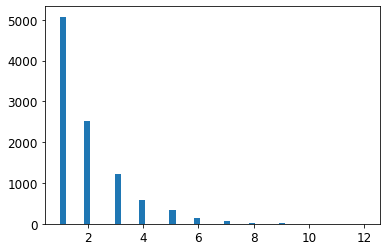

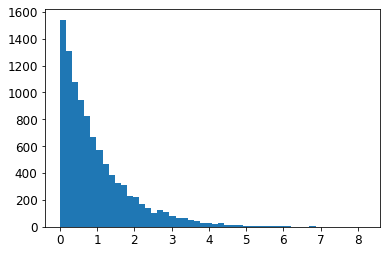

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

In [ ]:
temp = df1[df1.date == '2020-11-06']
temp['OPROA_rank'] = temp.OPROA.rank(ascending=False)
temp['GP_A_rank'] = temp.GP_A.rank(ascending=False)
temp['OPROA+GP_A_rank'] = temp['OPROA_rank'] + temp['GP_A_rank']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
temp.sort_values('OPROA+GP_A_rank')[:26].sort_values('GP_A_rank')[:6]

,itemname,date,PER,PBR,PCR,PSR,ROE,ROA,OPROA,OPROE,EV_EBITDA,GP_A,NOS,OPROA_rank,GP_A_rank,OPROA+GP_A_rank
1650788,고려신용정보,2020-11-06,8.840,3.392,11.786,1.215,40.68,17.29,18.939,44.248,5.54,2.424,7.736300e+07,56.0,2.0,58.0
73590,SCI평가정보,2020-11-06,11.551,6.969,25.330,6.093,66.76,45.64,56.825,73.646,9.58,1.805,1.771450e+08,8.0,5.0,13.0
1236656,랩지노믹스,2020-11-06,3.139,5.112,10.889,5.517,209.72,159.49,150.361,192.593,11.00,1.740,3.377110e+08,1.0,6.0,7.0
55022,미스터블루,2020-11-06,10.459,4.531,18.142,3.951,48.55,35.77,41.808,56.381,11.14,1.684,2.536568e+08,16.0,7.0,23.0
196284,씨젠,2020-11-06,13.810,22.571,42.180,20.238,212.31,137.58,135.173,218.205,24.67,1.652,7.216973e+09,2.0,8.0,10.0
550921,뉴트리,2020-11-06,12.107,2.962,19.414,2.192,26.71,17.86,22.505,33.333,9.55,1.439,1.955232e+08,41.0,11.0,52.0


# 연습문제 해답

## 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.0s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=  10.9s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  10.5s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.7s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=  10.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 44.3min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

## 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.2s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  51.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.1min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  56.8s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  44.5s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.3s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.5

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   6.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  36.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  35.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  56.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  37.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  30.7s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.6s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=251.14073886281363, gamma=0.8238105204914145, kernel=linear ...
[CV]  C=251.14073886281363, gamma=0.8238105204914145, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   6.8s
[CV] C=60.17373642891687, gamma=1.2491263443165994, kernel=linear ....
[CV]  C=60.17373642891687, gamma=1.2491263443165994, kernel=linear, total=   

[CV]  C=6287.039489427172, gamma=0.3504567255332862, kernel=linear, total=   8.4s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  37.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  43.1s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  40.6s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  41.5s
[CV] C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf .......
[CV]  C=61217.04421344494, gamma=1.6279689407405564, kernel=rbf, total=  38.6s
[CV] C=926.9787684096649, gamma=2.147979593060577, kernel=rbf ........
[CV]  C=926.9787684096649, gamma=2.147979593060577, kernel=rbf, total=  10.6s
[CV] C=926.97876840

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 68.0min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4cb149b50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff4ddacce10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084146

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

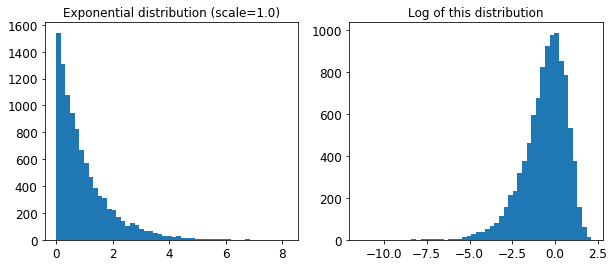

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 스케일이 정확이 무엇인지 모를 때 사용하면 좋습니다:

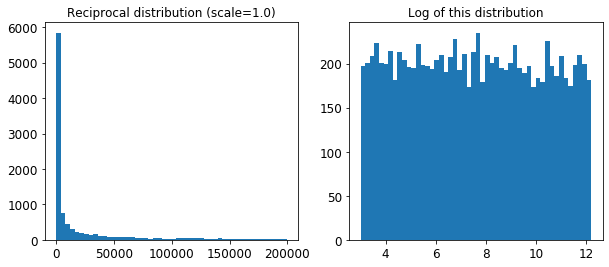

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 스케일을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

## 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [ ]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

성공입니다!  :)

## 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

## 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.7s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.2s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  10.5s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  11.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  13.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  23.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  22.9s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.2s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.1s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  28.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  25.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  27.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  24.7s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  25.9s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 68.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [ ]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.

축하합니다! 이제 머신러닝에 대해 꽤 많은 것을 알게 되었습니다. :)